# Compte-rendu du projet - Traitement du signal


Nous avons choisi de partir de zéro pour le fichier algorithme.py (renomé main.py) car cela me donne un peu plus de libertés pour structurer le code.

In [1]:
import main
import matplotlib.pyplot as plt
import numpy as np
from alive_progress import alive_bar
import performance_test

## Étape 1

On créer une classe `Encoding` qui permet d'encoder un morceau de musique et de créer sa signature. Cette classe permet des fonctionnalités de visualisation de base, sur une plage temporelle que l'on peut préciser:


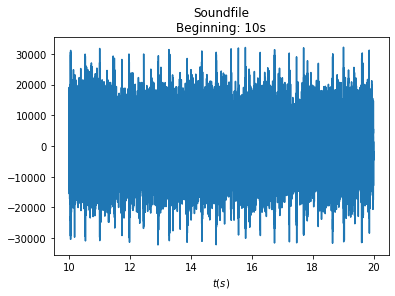

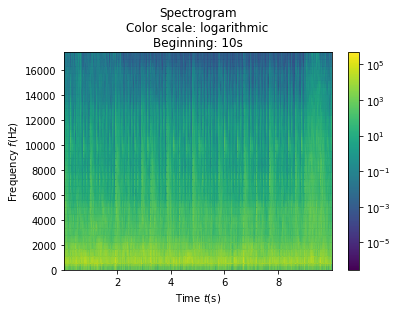

In [2]:
SoundFile = main.Encoding('samples\Frisk - Au.Ra.wav')
SoundFile.display((10,20))
SoundFile.display_spectrogram((10,20), max_freq=20000)

On affiche ici seulement les fréquences audibles (jusqu'à 20kHz)
On se demande comment est réparti l'énergie du signal sur le spectrogramme. Celle-ci est proportionnelle au carré des coefficients de Fourier. Lorsque l'on utilise la fonction `scipy.signal.spectrogram`, on obtient le carré des coefficients de Fourier dans une matrice (dont les dimensions dépendent de la longueur du morceau et des paramètres `nperseg` et `noverlap`.)  
Prenons un échantillons de musique de 10s, et regardons combien de coefficient permettent de caractériser 90% de l'énergie:

In [3]:
t, f, spec = SoundFile.spectrogram((10,20), max_freq=20000)
total_energy = spec.sum()
separator = 0
#On recherche les coefficients qui contiennent 90% de l'énergie à eux seuls:
while ((spec > separator)*spec).sum() > 0.9*total_energy:
    separator += 10**(-6)*total_energy

proportion = ((spec > separator)*spec).sum()/total_energy
N = (spec > separator).sum()
short_prop = "{0:.2f}".format(proportion*100)
coef_prop = "{0:.2f}".format(100*N/(spec>0).sum())

print(f"Sur cet exemple, {N} coefficients permettent de caractériser {short_prop}% de l'énergie du signal.")
print(f"Cela correspond à seulement {coef_prop}% des coefficients totaux!")

Sur cet exemple, 18411 coefficients permettent de caractériser 89.82% de l'énergie du signal.
Cela correspond à seulement 7.67% des coefficients totaux!


On peut voir sur cet exemple que **moins de 10% des coefficients** du spectrogramme suffisent à caractériser **90% de l'énergie!**  
  
Il est donc possible de caractériser le signal via une signature de données bien plus légère que les lourds échantillons de spectrogrammes.

## Étape 2: Constellations

Pour faire les *constellations*, on utilise la fonction `peak_local_max`. Il faut cependant choisir la distance minimale qui doit séparer deux pics. Le spectrogramme, avec les parmètres choisis, utilise aux alentours de 25 000 échantillons par seconde. On souhaite garder seulement les 1% de coefficients qui contiennent le plus d'information (d'énergie), soit environ 250 échantillons par seconde. On constate que l'algorithme final est efficace avec encore bien moins de coefficients.
  
Dans le code, la variable `MIN_DISTANCE` est **une variable à optimiser**. Cette variable détermine la quantité d'information que l'on va conserver pour caractériser le morceau. En testant plusieurs valeurs, on constate que fixer `MIN_DISTANCE` à 130 est un bon choix. Lorsque l'on regarde le nombre de points dans la constellation, on constate que **seulement 0,01% de l'information est conservée**!


In [4]:
import os
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

folder = './samples/'

import os
audiofiles = os.listdir(folder)
audiofiles = [item for item in audiofiles if item[-4:] =='.wav']

c=1
for file in audiofiles:
    sf = main.Encoding(folder+file)
    t, f, spec = sf.spectrogram((20,30), max_freq = 20000)
    pk = peak_local_max(spec, min_distance=130, exclude_border=False)
    rate = "{0:.2f}".format(100*len(pk)/spec.size)
    print(f"Échantillon n°{c}: on garde {rate}% de l'information")
    c+=1


Échantillon n°1: on garde 0.01% de l'information
Échantillon n°2: on garde 0.01% de l'information
Échantillon n°3: on garde 0.01% de l'information
Échantillon n°4: on garde 0.01% de l'information
Échantillon n°5: on garde 0.01% de l'information
Échantillon n°6: on garde 0.01% de l'information
Échantillon n°7: on garde 0.01% de l'information
Échantillon n°8: on garde 0.01% de l'information
Échantillon n°9: on garde 0.01% de l'information


## Étape 3: Signature

Nous allons maintenant procéder à l'éllaboration la signature. On introduit **deux nouvaux paramètres globaux à optimiser**:
* `DELTA_T`
* `DELTA_F`  

Ainsi, les cibles doivent se trouver à moins de `DELTA_T` secondes de leur ancre, et leur fréquence ne doit pas différer de plus de `DELTA_F` Hz.
Ces variables déterminent la façon dont on associes les *ancres* avec leurs *cibles*.
La constellation est la donnée qui rassemble sous forme de liste des couples ancre-cible. Ces derniers sont codés sous forme de dictionnaires: `{'t': t1, 'hash':(t2-t1,f1,f2)}` avec:
* t1 la position en temps de l'ancre
* t2 la position en temps de la cible
* f1 et f2 les positions respectives en fréquence de l'ancre et de la cible

On remarque que **l'attribut `'hash'` est invariant par translation** dans le temps.

Ces constellations sont des données **peu volumineuses** et **suffisantes pour caractériser** un morceau. Après avoir implémenter la méthode `Encoding.process()`, on peut alors former les constellations des différents morceaux de test situés dans le fichier *\samples* à l'aide du fichier `database.py`.

Voici une représentation des maximaux (en rouge) qui sont conservés pour construire la constellation (sur un échantillon de 1s):

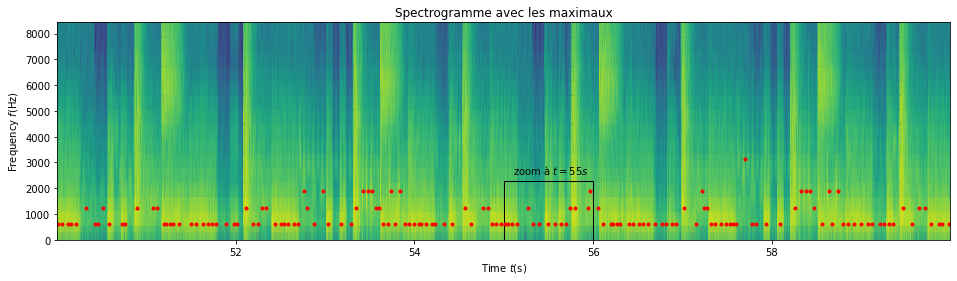

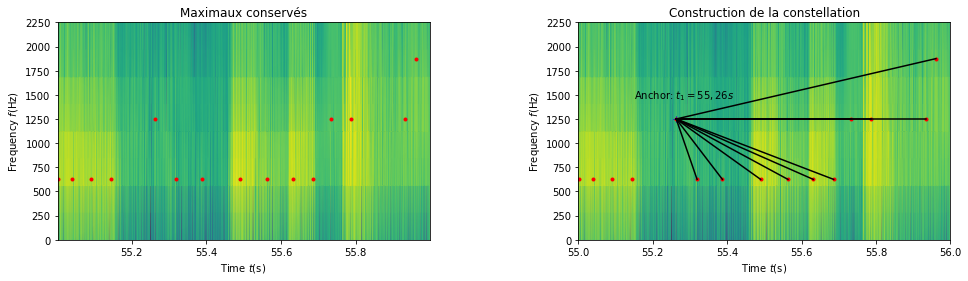

In [5]:
performance_test.Examples().constellation_example()

## Étape 4: Encodage des moreceaux

On execute le programme `database.py` afin de former les signatures des 9 morceaux test puis de les sérialiser.

## Étape 5: Comparaison de la signature de deux extraits

On souhaite comparer la signature d'un extrait musical avec celle d'un morceau complet pour voir si les deux correspondent. Pour cela, on va comparer les dictionnaires `{'t': t1, 'hash':(t2-t1,f1,f2)}` des signatures entre eutre eux, et retenir ceux qui ont leurs `hash` égaux (on accepte une erreur `EPSILON` pour `t2-t1`).  
On forme alors un nuage de points `(t1,t1')` qui rassemble la date des ancres pour lesquels il y a eu correspondance (on notera par la suite `(t1,t2)`).

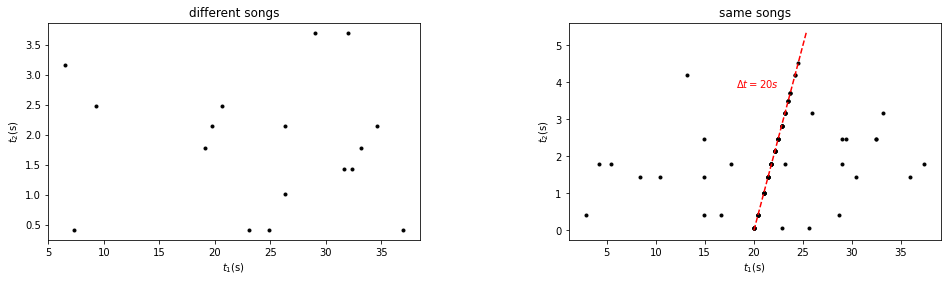

In [6]:
performance_test.Examples().comparison('scatterplot')

On peut voir que lorsque deux extraits sont issus du même morceaux, les points s'aligne sur une droite d'équation $y=x+b$ où $b$ est un déphasage temporel.

## Étape 6: histogramme

On représente sur un histogramme les quantités `t1-t2` pour le même exemple que précédemment.

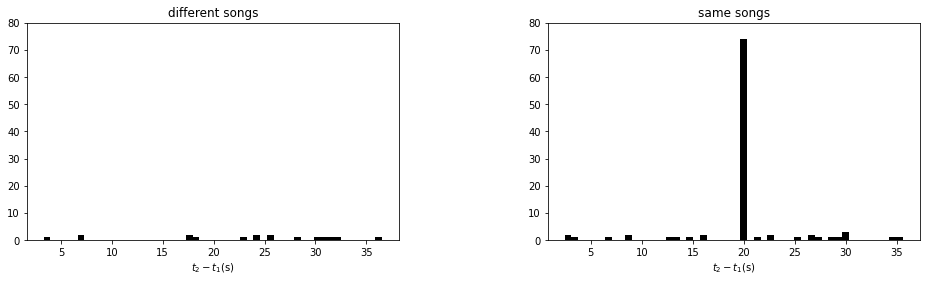

In [7]:
performance_test.Examples().comparison('histogram')

In [8]:
performance_test.Examples().comparison('same_song')

On cas de correspondance des morceaux, on pic se démarque des autres. Lorsque l'on compare un extrait au morceau entier, on obtient:

## Étape 7: Critère de décision

On choisi comme critère que le pic le plus grand de l'histogramme doit être 10 fois plus grand que le deuxième plus grand pic, ce qui s'avère largement vérifié pour cet exemple. Il ne faut cependant pas que le critère soit trop sévère: en effet, si l'échantillon test correspond au refrain d'un morceau, on peut alors observer des pics secondaires très importants qui correspondent au refrain qui est joué plusieurs fois quasiment à l'identique...

## Étape 8: Étude de la performance

In [9]:
test = performance_test.Test(samples_lenght=10, N=100)
test.run(display=True);

C:\Users\Tanguy\anaconda3\envs\python-advanced\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Test succeeded
Number of tests: 100
Number of success: 100
Success rate: 1.0
Processing time: 0.11s


On met en place un algorithme qui permet de tester l'algorithme N fois sur des échantillons de longueurs choisies. La fonction donne alors le taux de succès ainsi que le temps moyen que met l'algorithme à donner sa réponse. On se propose d'étudier également le temps moyen que met l'algorithme pour donner une réponse.  

**Attention**: La cellule qui suit nécessite plusieurs minutes de calcul.

C:\Users\Tanguy\Documents\Mines\info\traitement_du_signal\Mini-projet-énoncé\main.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  return sorted[-1]/sorted[-2] > k


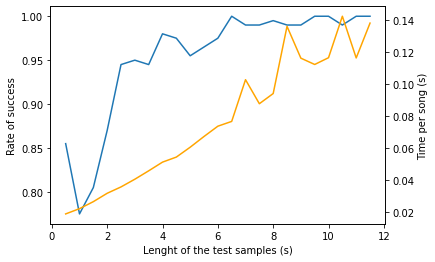

In [10]:
performance_test.Test().time_success()

On peut voir que l'algorithme a un très bon taux de succès. Celui-ci est meilleur si les échantillons de test sont longs, mais cela ralonge le temps que l'algorithme met pour nous donner une réponse.